## Neural Algorithm of Artistic Style

This notebook is a Pytorch implementation of style transfer technique proposed by [Gatys et al, 2016](https://arxiv.org/abs/1508.06576).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
device="cpu"
if torch.cuda.is_available():
    device="cuda"
print("Device: {}".format(device))

Device: cuda


#### Task
Given a content picture and a painting our goal is to impart the style in the painting to our picture while preserving its content. 

In [ ]:
content_img = Image.open("examples/iitd.jpg").resize((224,224))
style_img = Image.open("examples/starry-night.jpg").resize((224,224))

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(content_img)
ax[0].set_title("Content")
ax[1].imshow(style_img)
ax[1].set_title("Style")
plt.show()

#### Neural Networks as encoder of content and style

Neural Networks discover and encode features representing an image, with each layer learning more and more complex representations \[[Zeiler et al, 2013](https://arxiv.org/abs/1311.2901)\]. 

<img src="./examples/cnn-visualization.jpg" alt="cnn layer visualization" width="600x"/>

For a neural network trained for object classification, the deeper layers will encode an abstract notion of the object while the shallow layers will encode pixel level patterns. This paper exploits this intuition only.

Gatys et al. propose that the activations in a deep neural network trained on object classification task, activations of a deep layer encode the content of the image. Given activations of a layer from two input images, we can encode their content similarity by the similarity of their activations.

Further they propose that each channel of convolution layer capture certain distinct pattern. Interaction of these patterns encode stylistic aspect of images. Gatys et al. measure these interactions by Gram Matrix of activation. Difference between Gram matrix of two images represents difference in their styles.

Based on these two intuitions they define content and style loss for an input image. By minimizing these for a given content and style image, we learn parameters representing our desired image.

#### Architecture
We will use VGG19 as the pretrained model for encoding content and style. We will represent generated image by a tensor of the same shape as input content and style images. By minimizing content and style loss over this generated image we will hopefully converge at an image with desired properties. 

We will use 4^{th} convolution layer as the content layer while we will use convolutional layers from 1 to 5 as the style layers.

In [4]:
class EmbeddingGenerator(nn.Module):
    '''
    Compute activations in content and style layers using pretrained VGG19 model
    '''
    def __init__(self, content_layers=[4], style_layers=[1,2,3,4,5]):
        '''
        Input:
            content_layers: list of numbers indicating convolutional layers to use for content activations
            style_layers: list of numbers indicating convolutional layers to use for style activations
        '''
        super(EmbeddingGenerator, self).__init__()
        
        # load pretrained model and set requires grad to be false for each layer
        pretrained_model = models.vgg19(pretrained=True).features.eval().to(device)
        for layer in pretrained_model:
            layer.requires_grad = False
         
        # extract layers uptil the last of content and style layers
        self.pretrained_layers = []
        self.content_layers = []
        self.style_layers = []
        required_layers = max(max(content_layers), max(style_layers))
        conv_counter = 0
        for i,layer in enumerate(pretrained_model):
            if isinstance(layer,nn.Conv2d):
                conv_counter+=1
                if conv_counter>required_layers:
                    break
                if conv_counter in content_layers:
                    self.content_layers.append(i)
                if conv_counter in style_layers:
                    self.style_layers.append(i)
            
            self.pretrained_layers.append(layer)
        
        self.content_layers = set(self.content_layers)
        self.style_layers = set(self.style_layers)
        
        
    def forward(self, x):
        '''
        Input:
            x - Tensor of shape (1 x 3 x H X W)
        Returns:
            content_activations: list of flattened activations at content layers
            style_activations: list of activations at style layers with shape (n_C X (H*W))
        '''
        content_activations = []
        style_activations = []
        
        for i,layer in enumerate(self.pretrained_layers):
            x = layer(x)
            if i in self.content_layers:
                content_activations.append(x.flatten())
            
            if i in self.style_layers:
                style_activations.append(x.view(x.shape[1],-1))
        
        return content_activations, style_activations

In [5]:
embed = EmbeddingGenerator()

In [6]:
class StyleGenerator:
    '''
    Trainer class that generates output image
    '''
    def __init__(self, embedding_gen):
        '''
        Input:
            embedding_gen: object of EmbeddingGenerator class
        '''
        self.model = embedding_gen
        
        # for normalizing input content and style images
        self.preprocess = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
        # for denormalizing output image
        self.postprocess = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                               ])
        
    def gram_matrix(self,x):
        '''
        Compute Gram matrix for given 2D matrix
        '''
        return torch.matmul(x,x.transpose(0,1))/x.numel()

    def compute_content_loss(self,content_activations,inp_content_activations):
        '''
        Inputs:
            content_activations: content layer activations for content image
            inp_content_activations: content layer activations for generated image
        Returns:
            content_loss
        '''
        content_loss = 0.0
        for cont_activ, inp_cont_activ in zip(content_activations, inp_content_activations):
            diff = cont_activ-inp_cont_activ
            content_loss += torch.sum(torch.square(diff))/diff.numel()
        
        return content_loss
    
    def compute_style_loss(self, style_activations, inp_style_activations):
        '''
        Inputs:
            style_activations: style layer activations for style image
            inp_style_activations: style layer activations for generated image
        Returns:
            style_loss
        '''
        style_loss = 0.0
        for style_activ, inp_style_activ in zip(style_activations, inp_style_activations):
            diff = style_activ-inp_style_activ
            style_loss += torch.sum(torch.square(diff))
        
        return style_loss
    
    def generate_stylized_image(self, content_path, style_path, output_dir="images/",
                                content_wt=1.0, style_wt=1000.0, learning_rate=1.0, num_steps=400, image_size=(224,224)):
        '''
        Inputs:
            content_path: path to content image
            style_path: path to style image
            output_dir: output directory for intermediate generated images
            
            content_wt: factor controlling contribution of content loss to total loss
            style_wt: factor controlling contribution of style loss to total loss
            
            learning_rate: learning rate of optimizer
            num_steps: number of steps to be taken by optimizer
            
            image_size: tuple indicating size of input and output images to be used, default is input size expected by VGG19
        '''
        
        # create output directory
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        
        # load content and style images and compute relevant activations
        content_img = Image.open(content_path).resize(image_size)
        style_img = Image.open(style_path).resize(image_size)
        
        content = self.preprocess(content_img).unsqueeze(0).to(device)
        style = self.preprocess(style_img).unsqueeze(0).to(device)
        
        content_activations = [x.detach() for x in self.model(content)[0]]   
        style_activations = [self.gram_matrix(x.detach()) for x in self.model(style)[1]]

        # initialize output image with content image + noise, results in faster convergence
        gaussian_noise = torch.clamp(torch.randn(1,3,image_size[0], image_size[1]),-1,1)*0.5
        gen_image = content*0.5 + gaussian_noise.to(device)*0.5
        gen_image = nn.Parameter(gen_image)
        
        # initialize optimizer with gen_image as parameters over which optimization is carried out
        optimizer = torch.optim.LBFGS([gen_image.requires_grad_()], lr=learning_rate)
        
        # initialize as list to allow pass by reference in closure function
        runs=[0]
        while runs[0]<num_steps:
            def closure():
                '''
                closure function required by LBFGS optimizer
                '''
                optimizer.zero_grad()
                
                inp_content, inp_style = self.model(gen_image)
                inp_style = [self.gram_matrix(x) for x in inp_style]

                content_loss = self.compute_content_loss(content_activations, inp_content)
                style_loss = self.compute_style_loss(style_activations, inp_style)
                loss = content_wt*content_loss + style_wt*style_loss
                runs[0]+=1
                if runs[0]%40==0:
                    print("Num Steps: {} \tContent Loss: {} \tStyle Loss: {} \tTotal Loss:{}".format(runs[0], 
                                round(content_loss.item(),3), round(style_loss.item(),3), round(loss.item(),3)))
                    # save intermediate outputs
                    plt.imsave(os.path.join(output_dir,"epoch_"+str(runs[0])+".jpg"), 
                               torch.clamp(self.postprocess(gen_image[0].cpu().detach()).permute(1,2,0),0,1).numpy())

                loss.backward()
                return loss
            optimizer.step(closure)
                
        
        # save final image 
        fig,ax = plt.subplots(1,3, figsize=(15,5),facecolor='w')
        ax[0].imshow(content_img)
        ax[0].set_title("Content")
        ax[1].imshow(style_img)
        ax[1].set_title("Style")
        ax[2].imshow(torch.clamp(self.postprocess(gen_image[0].cpu().detach()).permute(1,2,0),0,1).numpy())
        ax[2].set_title("Generated")
        fig.savefig(os.path.join(output_dir,"final.jpg"))

#### Important implementation details 
* Use LBFGS as optimizer. Adam or SGD optimizer do not give sharp outputs.
* Remember to normalize input content and style images using mean and std deviation required by VGG19
* Remember to clamping output values and denormalize output image.
* Keep ratio of style_wt to content_wt more than 10, preferably around 100. Higher ratio leads to poor content preservation while low ratio leads to poor style replication.

In [7]:
styler = StyleGenerator(embed)

Num Steps: 40 	Content Loss: 5.768 	Style Loss: 0.115 	Total Loss:17.295
Num Steps: 80 	Content Loss: 5.289 	Style Loss: 0.023 	Total Loss:7.633
Num Steps: 120 	Content Loss: 4.572 	Style Loss: 0.012 	Total Loss:5.796
Num Steps: 160 	Content Loss: 4.16 	Style Loss: 0.01 	Total Loss:5.119
Num Steps: 200 	Content Loss: 3.92 	Style Loss: 0.008 	Total Loss:4.754
Num Steps: 240 	Content Loss: 3.768 	Style Loss: 0.008 	Total Loss:4.522
Num Steps: 280 	Content Loss: 3.661 	Style Loss: 0.007 	Total Loss:4.36
Num Steps: 320 	Content Loss: 3.58 	Style Loss: 0.007 	Total Loss:4.24
Num Steps: 360 	Content Loss: 3.522 	Style Loss: 0.006 	Total Loss:4.151
Num Steps: 400 	Content Loss: 3.473 	Style Loss: 0.006 	Total Loss:4.08


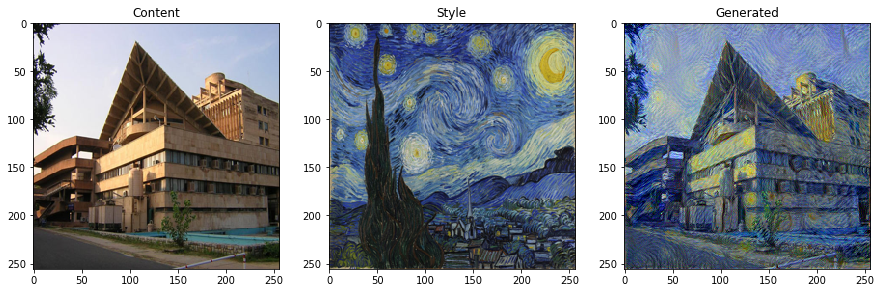

In [8]:
styler.generate_stylized_image(content_path="examples/iitd.jpg",style_path="examples/starry-night.jpg", output_dir="examples/iitd X starry_night/", 
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 3.754 	Style Loss: 0.036 	Total Loss:7.365
Num Steps: 80 	Content Loss: 3.09 	Style Loss: 0.016 	Total Loss:4.68
Num Steps: 120 	Content Loss: 2.748 	Style Loss: 0.01 	Total Loss:3.796
Num Steps: 160 	Content Loss: 2.575 	Style Loss: 0.008 	Total Loss:3.416
Num Steps: 200 	Content Loss: 2.47 	Style Loss: 0.007 	Total Loss:3.198
Num Steps: 240 	Content Loss: 2.406 	Style Loss: 0.007 	Total Loss:3.064
Num Steps: 280 	Content Loss: 2.363 	Style Loss: 0.006 	Total Loss:2.975
Num Steps: 320 	Content Loss: 2.332 	Style Loss: 0.006 	Total Loss:2.909
Num Steps: 360 	Content Loss: 2.31 	Style Loss: 0.005 	Total Loss:2.859
Num Steps: 400 	Content Loss: 2.292 	Style Loss: 0.005 	Total Loss:2.82


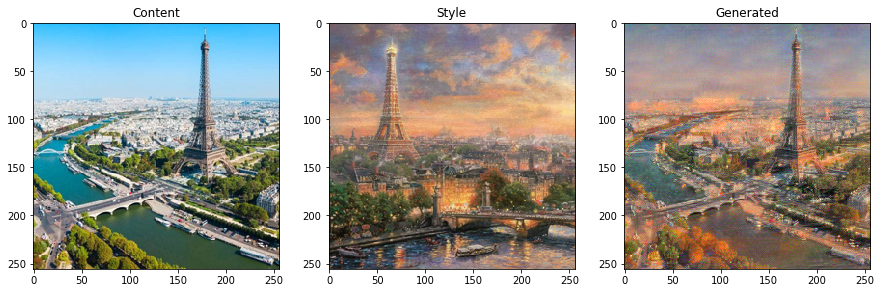

In [9]:
styler.generate_stylized_image(content_path="examples/paris.jpg",style_path="examples/paris_painting.jpg", output_dir="examples/paris",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 5.963 	Style Loss: 0.248 	Total Loss:30.808
Num Steps: 80 	Content Loss: 6.012 	Style Loss: 0.076 	Total Loss:13.584
Num Steps: 120 	Content Loss: 5.803 	Style Loss: 0.039 	Total Loss:9.67
Num Steps: 160 	Content Loss: 5.568 	Style Loss: 0.025 	Total Loss:8.117
Num Steps: 200 	Content Loss: 5.331 	Style Loss: 0.019 	Total Loss:7.28
Num Steps: 240 	Content Loss: 5.152 	Style Loss: 0.016 	Total Loss:6.775
Num Steps: 280 	Content Loss: 5.001 	Style Loss: 0.014 	Total Loss:6.42
Num Steps: 320 	Content Loss: 4.875 	Style Loss: 0.013 	Total Loss:6.158
Num Steps: 360 	Content Loss: 4.773 	Style Loss: 0.012 	Total Loss:5.961
Num Steps: 400 	Content Loss: 4.691 	Style Loss: 0.011 	Total Loss:5.812


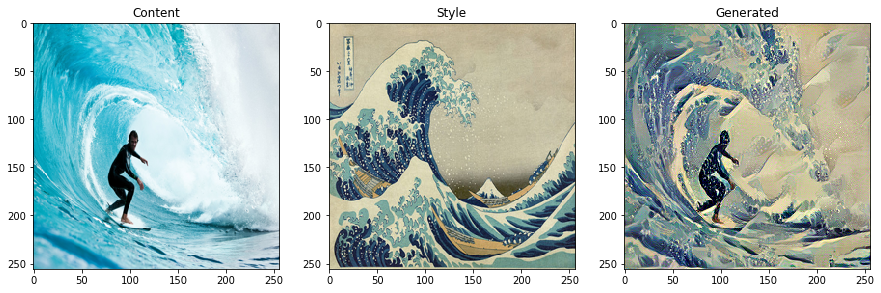

In [10]:
styler.generate_stylized_image(content_path="examples/surfer.jpg",style_path="examples/waves.jpg", output_dir="examples/surfer X waves/",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))